In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier

# 1. Load Data
bracket_train = pd.read_csv("bracket_training_cleaned.csv")
institutions = pd.read_csv("CCAC 2025 - Institutions_cleaned.csv")

# 2. Extract Geographical Data from Institutions Data
inst_geo = institutions[["InstitutionID", "InstitutionLatitude", "InstitutionLongitude", "InstitutionDMACode"]].copy()

# 3. Merge Geographical Data into "bracket_train"
regions = ["East", "West", "South", "Midwest"]
for region in regions:
    region_col = f"RegionWinner_{region}"
    inst_temp = inst_geo.copy()
    inst_temp.rename(columns={
        "InstitutionID": region_col,
        "InstitutionLatitude": f"{region}_Inst_Lat",
        "InstitutionLongitude": f"{region}_Inst_Long",
        "InstitutionDMACode": f"{region}_Inst_DMACode"
    }, inplace=True)
    bracket_train = bracket_train.merge(inst_temp, on=region_col, how="left")

# 4. Set Features
base_features = [
    "CustomerID",
    "CustomerDMACode",
    "BracketEntryId",
    "RegionWinner_East",
    "RegionWinner_West",
    "RegionWinner_South",
    "RegionWinner_Midwest",
    "NCAACustomerRecordCreated_Year",
    "NCAACustomerRecordCreated_Month",
    "BracketEntryCreatedDate_Year",
    "BracketEntryCreatedDate_Month"
]

geo_features = []
for region in regions:
    geo_features.extend([f"{region}_Inst_Lat", f"{region}_Inst_Long", f"{region}_Inst_DMACode"])

features = base_features + geo_features

In [3]:
targets = ["NationalChampion", "SemifinalWinner_East_West", "SemifinalWinner_South_Midwest"]
label_encoders = {}
for target in targets:
    le = LabelEncoder()
    bracket_train[target] = le.fit_transform(bracket_train[target])
    label_encoders[target] = le

bracket_train = bracket_train.fillna(0)

features_to_use = [col for col in features if col not in ["CustomerID", "BracketEntryId"]]

X = bracket_train[features_to_use]
y_nc = bracket_train["NationalChampion"]
y_semi_ew = bracket_train["SemifinalWinner_East_West"]
y_semi_sm = bracket_train["SemifinalWinner_South_Midwest"]

X_train, X_val, y_train_nc, y_val_nc = train_test_split(X, y_nc, test_size=0.2, random_state=42)
_, _, y_train_semi_ew, y_val_semi_ew = train_test_split(X, y_semi_ew, test_size=0.2, random_state=42)
_, _, y_train_semi_sm, y_val_semi_sm = train_test_split(X, y_semi_sm, test_size=0.2, random_state=42)

model_nc = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
model_semi_ew = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
model_semi_sm = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)

model_nc.fit(X_train, y_train_nc)
model_semi_ew.fit(X_train, y_train_semi_ew)
model_semi_sm.fit(X_train, y_train_semi_sm)

y_pred_nc = model_nc.predict(X_val)
acc_nc = accuracy_score(y_val_nc, y_pred_nc)
print("Validation Accuracy - NationalChampion:", acc_nc)

Validation Accuracy - NationalChampion: 0.45788945499459627


In [11]:
import pickle

with open("model_nc_geo.pkl", "wb") as f:
    pickle.dump(xgb_nc, f)

with open("model_semi_ew_geo.pkl", "wb") as f:
    pickle.dump(xgb_semi_ew, f)

with open("model_semi_sm_geo.pkl", "wb") as f:
    pickle.dump(xgb_semi_sm, f)

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_85924/1472198783.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")


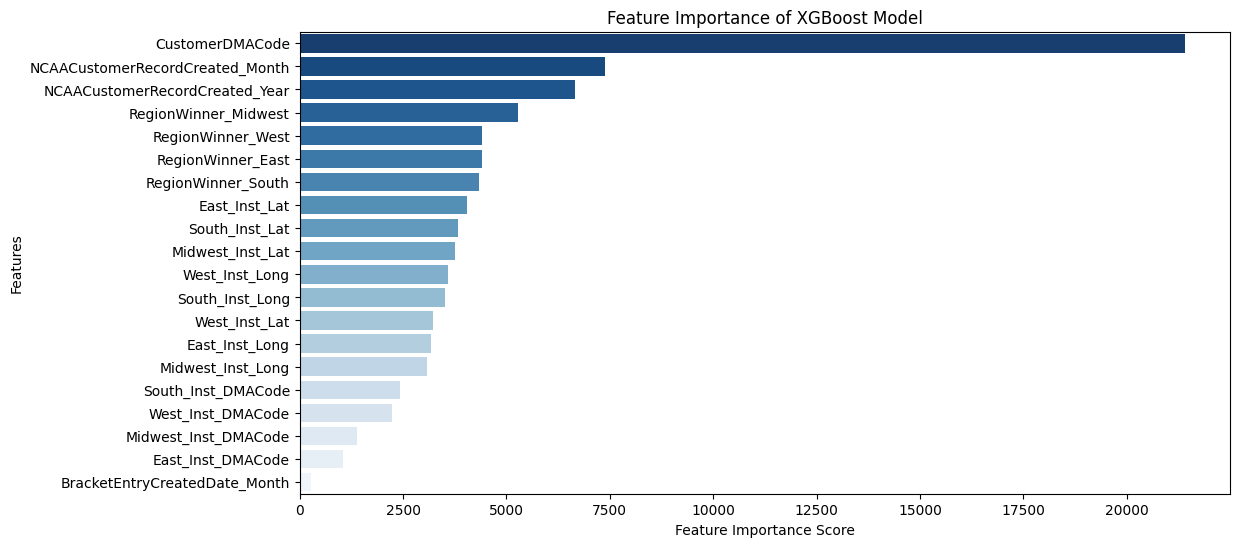

🔹 Feature Importance Results:
                            Feature  Importance
0                   CustomerDMACode     21417.0
6   NCAACustomerRecordCreated_Month      7392.0
5    NCAACustomerRecordCreated_Year      6670.0
4              RegionWinner_Midwest      5270.0
2                 RegionWinner_West      4406.0
1                 RegionWinner_East      4399.0
3                RegionWinner_South      4330.0
8                     East_Inst_Lat      4055.0
14                   South_Inst_Lat      3820.0
17                 Midwest_Inst_Lat      3759.0
12                   West_Inst_Long      3581.0
15                  South_Inst_Long      3519.0
11                    West_Inst_Lat      3214.0
9                    East_Inst_Long      3166.0
18                Midwest_Inst_Long      3088.0
16               South_Inst_DMACode      2416.0
13                West_Inst_DMACode      2228.0
19             Midwest_Inst_DMACode      1387.0
10                East_Inst_DMACode      1052.0
7     Brac

In [66]:
feature_importance1 = model_nc.get_booster().get_score(importance_type="weight")
                                                       
importance_df = pd.DataFrame({"Feature": feature_importance1.keys(), "Importance": feature_importance1.values()})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance of XGBoost Model")
plt.show()

print("🔹 Feature Importance Results:")
print(importance_df)

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_85924/1908786764.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df2, palette="Blues_r")


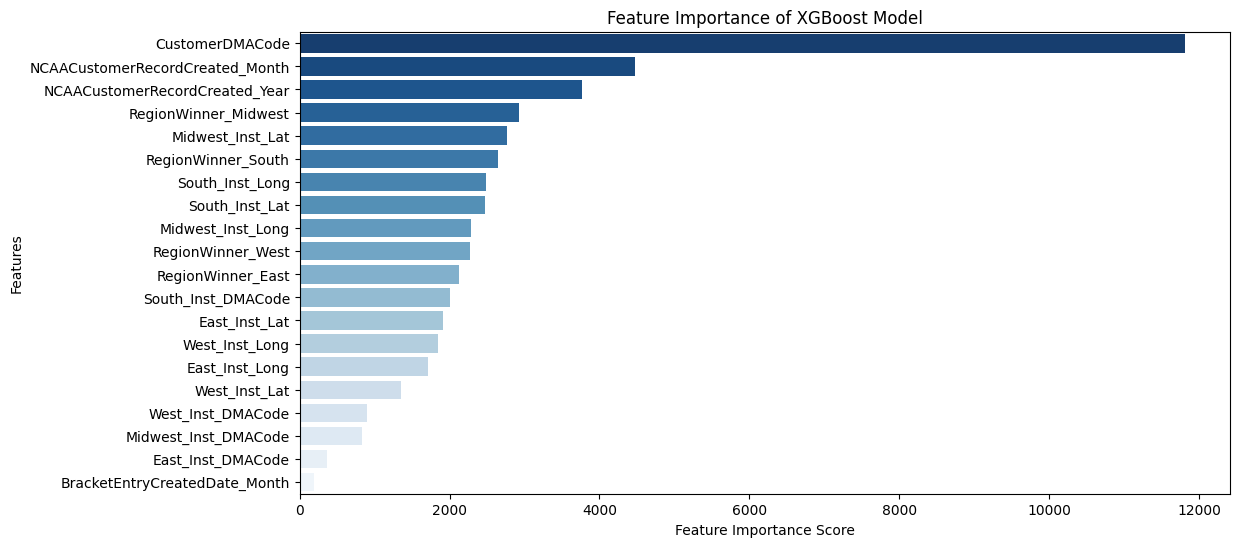

🔹 Feature Importance Results:
                            Feature  Importance
0                   CustomerDMACode     11816.0
6   NCAACustomerRecordCreated_Month      4473.0
5    NCAACustomerRecordCreated_Year      3767.0
4              RegionWinner_Midwest      2923.0
17                 Midwest_Inst_Lat      2770.0
3                RegionWinner_South      2641.0
15                  South_Inst_Long      2491.0
14                   South_Inst_Lat      2472.0
18                Midwest_Inst_Long      2288.0
2                 RegionWinner_West      2269.0
1                 RegionWinner_East      2132.0
16               South_Inst_DMACode      2003.0
8                     East_Inst_Lat      1910.0
12                   West_Inst_Long      1844.0
9                    East_Inst_Long      1713.0
11                    West_Inst_Lat      1357.0
13                West_Inst_DMACode       901.0
19             Midwest_Inst_DMACode       834.0
10                East_Inst_DMACode       363.0
7     Brac

In [68]:
feature_importance2 = model_semi_ew.get_booster().get_score(importance_type="weight")
importance_df2 = pd.DataFrame({"Feature": feature_importance2.keys(), "Importance": feature_importance2.values()})
importance_df2 = importance_df2.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="Importance", y="Feature", data=importance_df2, palette="Blues_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance of XGBoost Model")
plt.show()

print("🔹 Feature Importance Results:")
print(importance_df2)

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_85924/4285722655.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df3, palette="Blues_r")


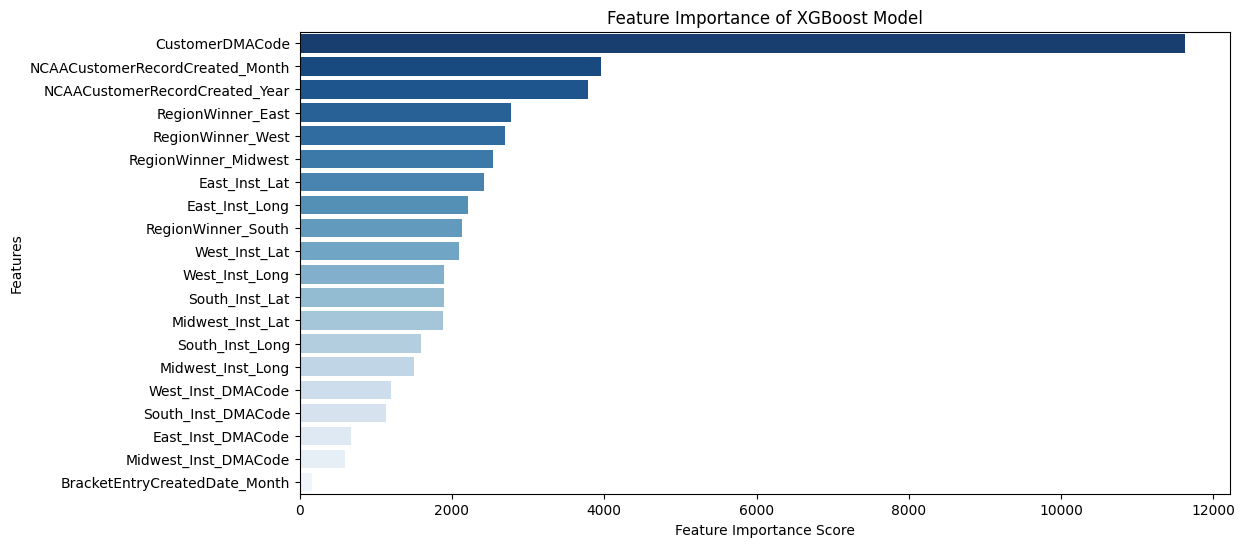

🔹 Feature Importance Results:
                            Feature  Importance
0                   CustomerDMACode     11631.0
6   NCAACustomerRecordCreated_Month      3962.0
5    NCAACustomerRecordCreated_Year      3787.0
1                 RegionWinner_East      2780.0
2                 RegionWinner_West      2691.0
4              RegionWinner_Midwest      2536.0
8                     East_Inst_Lat      2423.0
9                    East_Inst_Long      2211.0
3                RegionWinner_South      2136.0
11                    West_Inst_Lat      2092.0
12                   West_Inst_Long      1902.0
14                   South_Inst_Lat      1892.0
17                 Midwest_Inst_Lat      1884.0
15                  South_Inst_Long      1588.0
18                Midwest_Inst_Long      1508.0
13                West_Inst_DMACode      1196.0
16               South_Inst_DMACode      1139.0
10                East_Inst_DMACode       674.0
19             Midwest_Inst_DMACode       591.0
7     Brac

In [70]:
feature_importance3 = model_semi_sm.get_booster().get_score(importance_type="weight")
importance_df3 = pd.DataFrame({"Feature": feature_importance3.keys(), "Importance": feature_importance3.values()})
importance_df3 = importance_df3.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="Importance", y="Feature", data=importance_df3, palette="Blues_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance of XGBoost Model")
plt.show()

print("🔹 Feature Importance Results:")
print(importance_df3)